In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import ee
import io
import PyIF
import tqdm
import json
import fiona
import datetime
import requests
import urllib.request

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns
import multiprocessing as mp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from sklearn import metrics
from scipy import stats, spatial
from affine import Affine
from datetime import timedelta
from rasterio import features, mask
from climata.usgs import DailyValueIO
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

ee.Initialize()

%load_ext autoreload
%autoreload 2

/anaconda3/envs/pysheds/lib/python3.8/site-packages/numba/core/decorators.py:232: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# The math


#### Entropy: 

Given a discrete random variable $X$, with possible outcomes $ x_{1},...,x_{n} $ which occur with probability $  \mathrm {P} (x_{1}),...,\mathrm {P} (x_{n}) $ the entropy (units of nats) of $X$ is defined as: <br>

$ H(X) =  - \sum_{i=1}^{n} P(x) \ln P(x) $

#### Joint Entropy:
of two discrete random variables $X$ and $Y$ is defined as the entropy of the joint distribution of $X$ and $Y$:

$ H(X,Y) =  - \sum_{i=1}^{n} P(x,y) \ln P(x,y) $


#### Conditional Entropy: 

The amount of information needed to describe the outcome of a random variable $Y$ given that the value of another random variable $X$ is known. Here, information is measured in shannons, nats, or hartleys. The entropy of $Y$ conditioned on $X$ is:

$ H (Y|X) = -\sum p(x,y)\ln {\frac {p(x,y)}{p(x)}} $


#### Relative Entropy, aka K-L Divergence,

The Relative Entropy (aka K-L divergence, $ D_{\text{KL}}(P\parallel Q)$ ), which measures how one probability distribution $P(x)$ is different from a second $Q(x)$ is defined as:

$ D_{\text{KL}}(P\parallel Q)=\sum _{x\in {\mathcal {X}}}P(x)\ln \left({\frac {P(x)}{Q(x)}}\right)$

#### Jensen Shannon Distance:

The Jensen Shannon Distance (JSD) also measures how one probability distribution $P(x)$ is different from a second $Q(x)$, but has desirable properties of always being finite and symmetric: 

$ JSD(X) = \sqrt{\frac{D(p \parallel m) + D(q \parallel m)}{2}}\$

where $D(x \parallel y)$ is the K-L Divergence, defined above.


#### Mutual information

measures how much information can be obtained about one random variable by observing another. The mutual information of $X$ relative to $Y$ (which represents conceptually the average amount of information about $X$ that can be gained by observing $Y$ is given by:

$ I(X; Y)=H(X)− H(X|Y)= -\sum p(x,y)\ln \frac{p(x,y)}{p(x) p(y)} $

We will use $H(x)$ and $JSD(x)$ with P(x) as the 2003 - 2020 P, SWE, and dSWE/dt and Q(x) as reservoir inflow. 


In [2]:
def get_snodas_swe(shppath,startdate,enddate, data_dir ="/Users/aakash/Desktop/SatDat/GRACE/SNODAS_GRACE_processed/" ):
    '''
    Given a path to a shapefile, compute the monthly SWE
    Input: (str) - path to shapefile
    Output: (pd.DataFrame) - daily SWE 
    '''
    # Datetime the start/end
    start = datetime.datetime.strptime(startdate, "%Y-%m-%d")
    end = datetime.datetime.strptime(enddate, "%Y-%m-%d")
    dt_idx = pd.date_range(start,end, freq='D')
    
    # Find SWE files
    files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
    files.sort()

    # Read shapefile
    with fiona.open(shppath, "r") as shapefile:
        area_geom = [feature["geometry"] for feature in shapefile]

    # Read the files, mask nans, clip to area, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.datetime.strptime(i[-16:-8],'%Y%m%d')# Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        if date >= start and date <= end:
            src = rio.open(i) # Read file
            src2 = rio.mask.mask(src, area_geom, crop=True) # Clip to shp 
            arr = src2[0].astype(float) # read as array
            arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
            arr[arr < 0 ] = np.nan # Mask nodata vals 
            imdict[datestr] = arr/1000 # divide by scale factor to get SWE in m 
    
    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
    
    return all_dates
            
def get_res_data(stid, startdate, enddate, freq = 'D', var = 'inflow'):
    '''
    Fetch CDEV reservoir data via api 
    Input Params: 
        stid (str) - 3 letter station id (ex: ISB)
        startdate - 'YYYY-mm-dd'
        startdate - 'YYYY-mm-dd'
        freq - "D" = Day, "M" = Month
    
    Output: inflow - (pd.DataFrame)
    '''
    varlookup = {
                    'storage':'65',
                    'inflow':'76'}
    
    # build the api query from params
    query = '''https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums={}&dur_code={}&Start={}&End={}'''.format(stid,varlookup[var],freq,startdate,enddate)
    print(query)
    # Read, extract relevant cols as float and datetime, return df
    dat = pd.read_csv(query)
    vals = pd.to_numeric(dat['VALUE'], errors = 'coerce')
    dt = pd.to_datetime(dat['DATE TIME'])
    indf = pd.DataFrame(zip(dt,vals* 0.0283168), columns = ['date',"q_cms"]) # cfs --> CMS 
    
    return indf


def dict2im(outdict, empty_im, rclist=None):
    outim = np.zeros_like(empty_im)
    outdf = pd.DataFrame.from_dict(outdict)

    # Populate the per-pixel entropy 
    for rc, dfcolidx in zip(rclist,outdf.columns):

        rowidx, colidx = rc
        val = outdf[dfcolidx].values[0]
        outim[rowidx,colidx] = val
        
    return outim


def calc_nbins(N):
    
    
    '''
    A. Hacine-Gharbi, P. Ravier, "Low bias histogram-based estimation of mutual information for feature selection", Pattern Recognit. Lett (2012).
    '''
    ee = np.cbrt(8 + 324*N + 12*np.sqrt(36*N + 729*N**2))
    bins = np.round(ee/6 + 2/(3*ee) + 1/3)

    return int(bins)

def split_before_after(imstack, beforeidx,afteridx):
    beforeim = imstack[:,:,:beforeidx]
    afterim = imstack[:,:,-afteridx:]
    return beforeim, afterim

def mask_unpack(imlist, meanim):
    im1, im2, im3 = [np.ma.masked_array(x, mask=np.isnan(meanim)) for x in imlist]
    return im1, im2, im3

def calc_main(imstack, dt_idx = None, dswe = False, inflow = None):

    rows, cols, time = imstack.shape
    px_ts = []
    rclist = []

    # extract pixelwise timeseries
    for row in range(rows):
        for col in range(cols):
            ts_arr = imstack[row,col,:]
            if not np.isnan(ts_arr).all():

                px_ts.append(pd.Series(ts_arr))
                rclist.append([row,col])

    pxdf = pd.concat(px_ts, axis = 1)

    # if time derivative, we have to ditch the first date 
    pxdf.columns = pxdf.columns.map(str)
    if dswe:
        pxdf.index = dt_idx[1:]
    else:
        pxdf.index = dt_idx
    pxdf.columns = pxdf.columns.map(str)

    # Filter infs
    pxdf = pxdf[~pxdf.isin([np.nan, np.inf, -np.inf]).any(1)]

    # Merge w inflow  
    mdf = pd.merge(inflow, pxdf, left_index = True, right_index = True)

    # Drop nans, infs, etc 
    itdf = mdf[mdf['q_cms'].notna()]
    itdf = itdf[~itdf.isin([np.nan, np.inf, -np.inf]).any(1)]
    target = itdf['q_cms']
    itdf.drop(['q_cms'], axis =1 , inplace = True)

    # Build the out image
    outim = np.zeros_like(imstack[:,:,0])

    # get n bins
    nbins = calc_nbins(len(itdf))

    # Setup out dicts to store calcs 
    was_dict = {}
    js_dict = {}
    mi_dict = {}
    te_dict = {}

    # Loop through the cols, calc stuff 
    for pxidx in tqdm(itdf.columns[:]):

        vals = pd.Series(itdf[[pxidx]].values.reshape(itdf[[pxidx]].values.shape[0]))#.value_counts(normalize = True, bins =20)
        vals[~np.isfinite(vals)] = 0
        tempdf = pd.DataFrame([vals,target.values]).T
        tempdf.columns = ['var','q_cms']
        mi = metrics.mutual_info_score(tempdf['var'].value_counts(normalize=True,bins = 250),tempdf['q_cms'].value_counts(normalize=True,bins = 250))
        js_dist = spatial.distance.jensenshannon(tempdf['var'].value_counts(normalize=True,bins = nbins),tempdf['q_cms'].value_counts(normalize=True,bins = nbins))
        TE = PyIF.te_compute.te_compute(np.array(tempdf['var'].values),np.array(tempdf['q_cms'].values))
        
        js_dict[pxidx] = [js_dist]
        mi_dict[pxidx] = [mi]
        te_dict[pxidx] = [TE]
                                    
    te_im = dict2im(te_dict, outim, rclist = rclist)
    te_im[te_im == 0] = np.nan
    js_im = dict2im(js_dict, outim, rclist = rclist)
    js_im[js_im==0] = np.nan
    mi_im = dict2im(mi_dict, outim, rclist = rclist)
    mi_im[mi_im == 0] = np.nan

    return te_im, js_im, mi_im

def plot_mean_ims(p_mean,swe_mean,dswe_mean,  stid = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(131)
    ax1.set_title("mean P")
    im = ax1.imshow(p_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(132)
    ax2.set_title("mean SWE")
    im2 = ax2.imshow(swe_mean * 365)
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)
    
    ax3 = plt.subplot(133)
    ax3.set_title("mean ∆SWE")
    im3 = ax3.imshow(dswe_mean)
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    plt.tight_layout()
    plt.savefig('../figures/{}_mean.png'.format(stid))
    
    return plt.show()
    
def plot_before_after(beforeims, afterims,var = None, stid = None, fire_name = None):

    plt.figure(figsize = (10,7))

    ax1 = plt.subplot(231)
    ax1.set_title("Before TE ({})".format(var))
    im = ax1.imshow(beforeims[0])
    plt.axis('off')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    ax2 = plt.subplot(232)
    ax2.set_title("Before JSD ({})".format(var))
    im2 = ax2.imshow(beforeims[1])
    plt.axis('off')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax)

    ax3 = plt.subplot(233)
    ax3.set_title("Before MI ({})".format(var))
    im3 = ax3.imshow(beforeims[2])
    plt.axis('off')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax)
    
    ax4 = plt.subplot(234)
    ax4.set_title("After TE ({})".format(var))
    im4 = ax4.imshow(afterims[0])
    plt.axis('off')
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im4, cax=cax)

    ax5 = plt.subplot(235)
    ax5.set_title("After JSD ({})".format(var))
    im5 = ax5.imshow(afterims[1])
    plt.axis('off')
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax)
    
    ax5 = plt.subplot(236)
    ax5.set_title("After MI ({})".format(var))
    im5 = ax5.imshow(afterims[2])
    plt.axis('off')
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im5, cax=cax)
    
    plt.suptitle("TE, JSD, MI Before / After {} ".format(fire_name))
    plt.tight_layout()
    plt.savefig('../figures/{}_{}_b_a.png'.format(fire_name,stid))

    return plt.show()

In [3]:
# Read catchments, reservoirs
gdf = gp.read_file("../shape/sierra_catchments.shp")

# Set start / end date
startdate = '1950-09-30'
enddate = '2020-10-01'
dt_idx = pd.date_range(startdate,enddate, freq='D')

outdir = "../rasters/InfoTheory_H_CE_MI_JSD"

### download the fire data from: 
https://frap.fire.ca.gov/media/10969/fire19_1.zip

In [4]:
# Read
firedat = gp.read_file("/Users/aakash/Downloads/California_Fire_Perimeters-shp/California_Fire_Perimeters__all_.shp")
firedat.to_crs(gdf.crs, inplace=True)

/anaconda3/envs/pysheds/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
# Intersect w watersheds
firesheds = gp.sjoin(firedat, gdf, how='inner',op='intersects')
aff_firesheds = firedat.geom_almost_equals(firesheds)
aff_firesheds = aff_firesheds[~aff_firesheds.index.duplicated()]
fs_subset = firesheds[aff_firesheds]


/anaconda3/envs/pysheds/lib/python3.8/site-packages/geopandas/geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


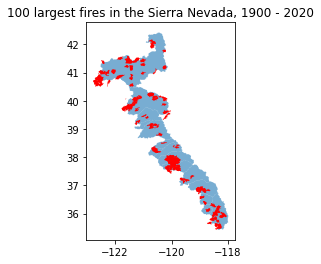

In [6]:
# Plot intersection 
base = gdf.plot(alpha = 0.6)
fs_subset.sort_values(['GIS_ACRES'], ascending = False)[:100].plot(ax=base,color = 'red')
plt.title("100 largest fires in the Sierra Nevada, 1900 - 2020")
plt.show()

In [7]:
years = []
acres = []
nfires = []

for year in fs_subset['YEAR_'].sort_values(ascending = True).unique():
    if year is not None:    
        yearfires = firedat[firedat['YEAR_'] == year]
        yearacres = yearfires['GIS_ACRES'].sum()
        years.append(int(year))
        acres.append(yearacres)
        nfires.append(len(yearfires))

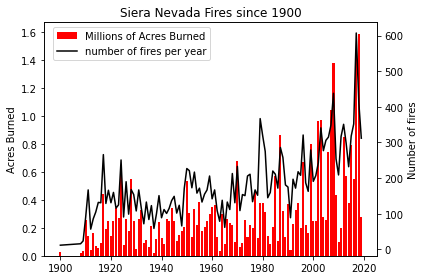

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.bar(years, [x*1e-6 for x in acres], color = 'red', label = 'Millions of Acres Burned')
ax1.set_ylabel("Acres Burned")
ax2 = ax1.twinx()
ax2.plot(years, nfires, color = 'black', label = 'number of fires per year')
ax2.set_ylabel("Number of fires")
fig.legend(loc="upper left",bbox_to_anchor=(0.01,1), bbox_transform=ax1.transAxes)

plt.title("Siera Nevada Fires since 1900")
plt.tight_layout()
plt.show()

In [14]:
# Pick the top 10 
topten = fs_subset[fs_subset['YEAR_'] > "2003"].sort_values('GIS_ACRES', ascending = False)[:10]

************************************************************
Processing Fire ID: RIM within catchment: TUOLUMNE R with reservoir terminus: DNP
2013-08-17 2013-10-24 256175.5 DNP


<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


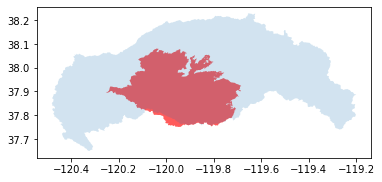

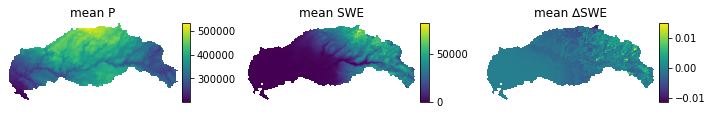

100%|██████████| 5813/5813 [10:37<00:00,  9.12it/s]


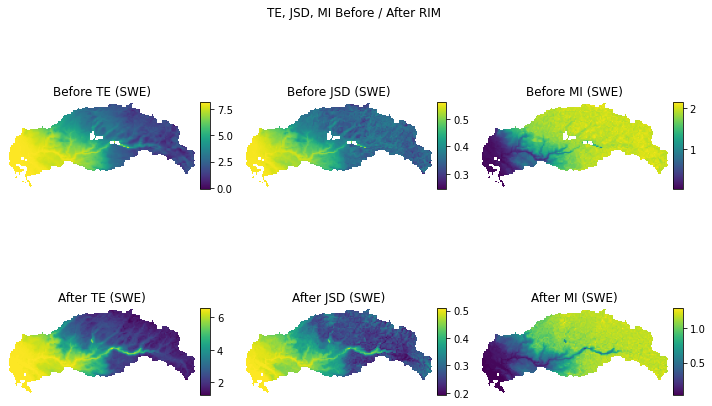

100%|██████████| 9230/9230 [16:55<00:00,  9.09it/s]


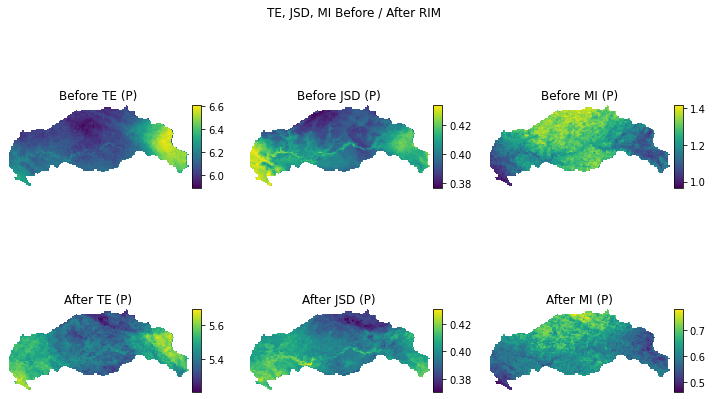

100%|██████████| 5813/5813 [10:47<00:00,  8.97it/s]


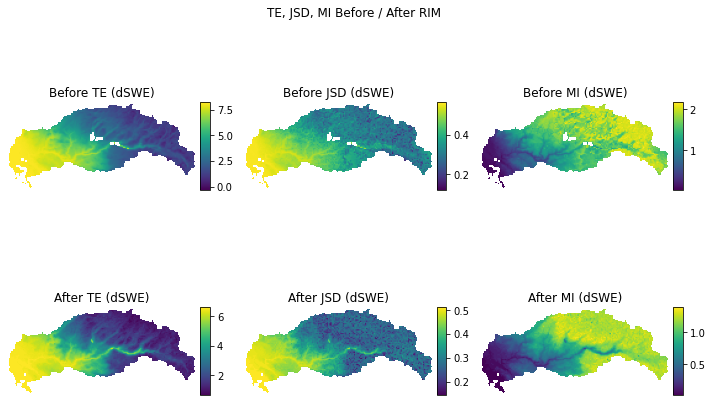

wrote ../rasters/Fire/RIM_DNP_b4_p_jsd.tif
wrote ../rasters/Fire/RIM_DNP_b4_swe_jsd.tif
wrote ../rasters/Fire/RIM_DNP_b4_dswe_jsd.tif
wrote ../rasters/Fire/RIM_DNP_aft_p_jsd.tif
wrote ../rasters/Fire/RIM_DNP_aft_swe_jsd.tif
wrote ../rasters/Fire/RIM_DNP_aft_dswe_jsd.tif
wrote ../rasters/Fire/RIM_DNP_b4_p_te.tif
wrote ../rasters/Fire/RIM_DNP_b4_swe_te.tif
wrote ../rasters/Fire/RIM_DNP_b4_dswe_te.tif
wrote ../rasters/Fire/RIM_DNP_aft_p_te.tif
wrote ../rasters/Fire/RIM_DNP_aft_swe_te.tif
wrote ../rasters/Fire/RIM_DNP_aft_dswe_te.tif
wrote ../rasters/Fire/RIM_DNP_b4_p_mi.tif
wrote ../rasters/Fire/RIM_DNP_b4_swe_mi.tif
wrote ../rasters/Fire/RIM_DNP_b4_dswe_mi.tif
wrote ../rasters/Fire/RIM_DNP_aft_p_mi.tif
wrote ../rasters/Fire/RIM_DNP_aft_swe_mi.tif
wrote ../rasters/Fire/RIM_DNP_aft_dswe_mi.tif
************************************************************
Processing Fire ID: RIM within catchment: MERCED R with reservoir terminus: MCR
2013-08-17 2013-10-24 256175.5 MCR
no data for MCR
*******

<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


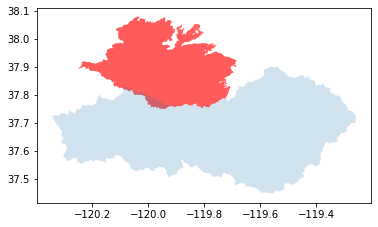

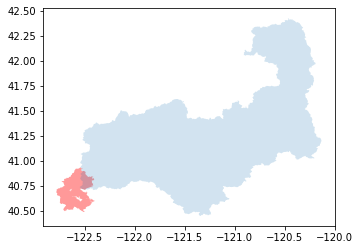

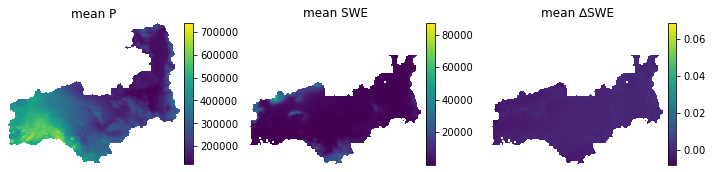

100%|██████████| 26800/26800 [49:39<00:00,  8.99it/s]


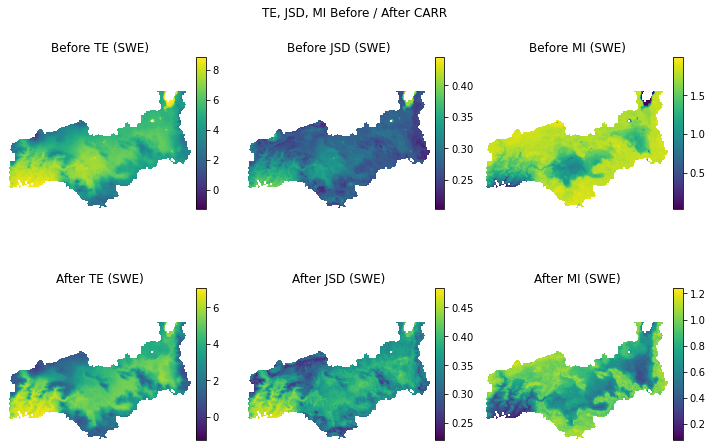

100%|██████████| 58911/58911 [2:08:19<00:00,  7.65it/s]  


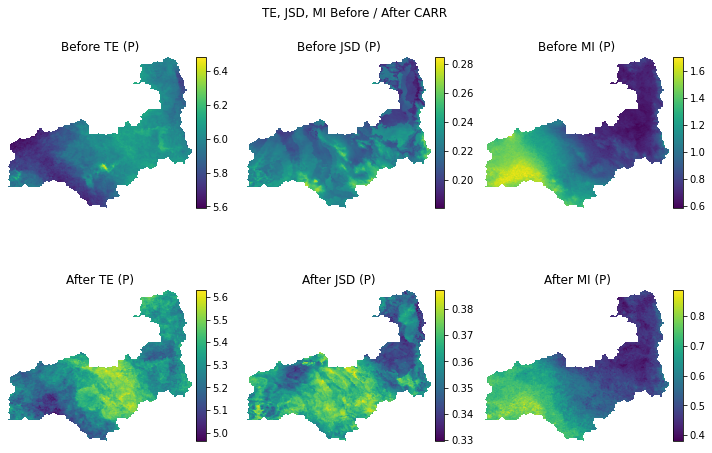

100%|██████████| 26800/26800 [49:16<00:00,  9.06it/s] 


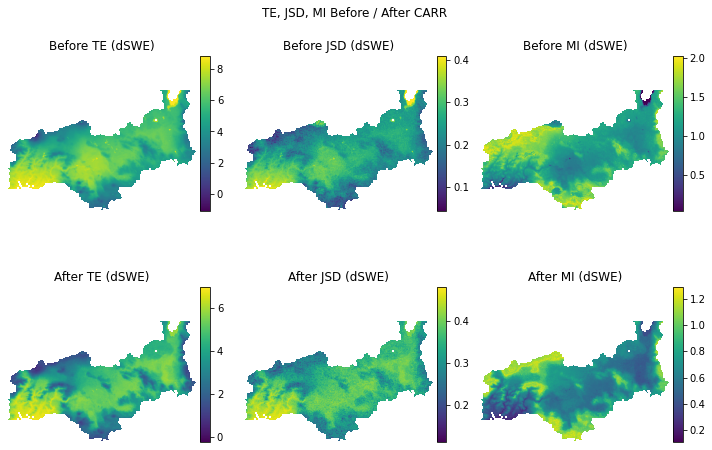

wrote ../rasters/Fire/CARR_SHA_b4_p_jsd.tif
wrote ../rasters/Fire/CARR_SHA_b4_swe_jsd.tif
wrote ../rasters/Fire/CARR_SHA_b4_dswe_jsd.tif
wrote ../rasters/Fire/CARR_SHA_aft_p_jsd.tif
wrote ../rasters/Fire/CARR_SHA_aft_swe_jsd.tif
wrote ../rasters/Fire/CARR_SHA_aft_dswe_jsd.tif
wrote ../rasters/Fire/CARR_SHA_b4_p_te.tif
wrote ../rasters/Fire/CARR_SHA_b4_swe_te.tif
wrote ../rasters/Fire/CARR_SHA_b4_dswe_te.tif
wrote ../rasters/Fire/CARR_SHA_aft_p_te.tif
wrote ../rasters/Fire/CARR_SHA_aft_swe_te.tif
wrote ../rasters/Fire/CARR_SHA_aft_dswe_te.tif
wrote ../rasters/Fire/CARR_SHA_b4_p_mi.tif
wrote ../rasters/Fire/CARR_SHA_b4_swe_mi.tif
wrote ../rasters/Fire/CARR_SHA_b4_dswe_mi.tif
wrote ../rasters/Fire/CARR_SHA_aft_p_mi.tif
wrote ../rasters/Fire/CARR_SHA_aft_swe_mi.tif
wrote ../rasters/Fire/CARR_SHA_aft_dswe_mi.tif
************************************************************
Processing Fire ID: CAMP within catchment: FEATHER R with reservoir terminus: ORO
2018-11-08 2018-11-26 153335.5625 ORO


<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


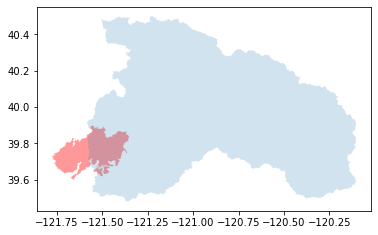

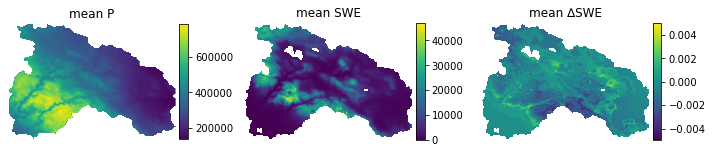

100%|██████████| 14056/14056 [24:39<00:00,  9.50it/s]


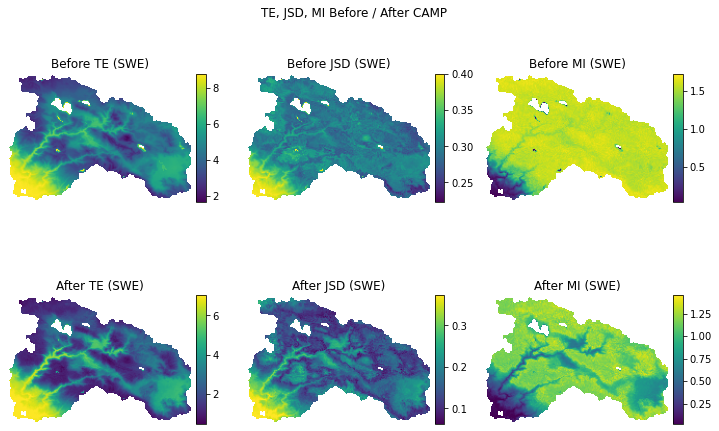

100%|██████████| 18645/18645 [32:22<00:00,  9.60it/s]


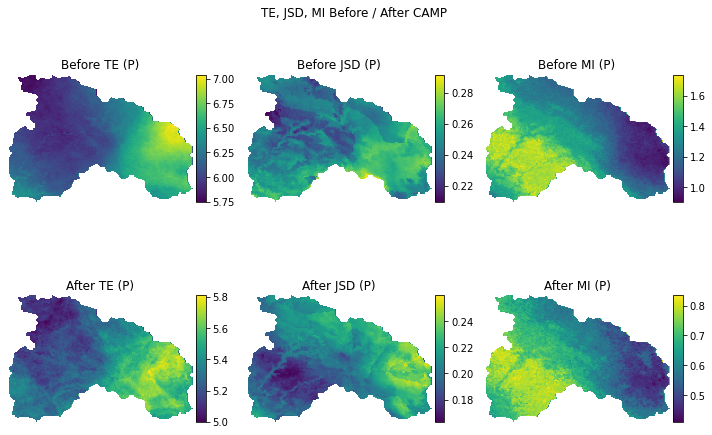

100%|██████████| 14056/14056 [24:53<00:00,  9.41it/s]


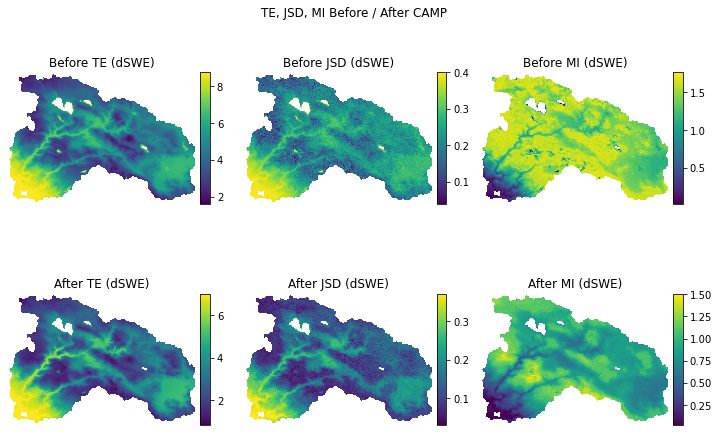

wrote ../rasters/Fire/CAMP_ORO_b4_p_jsd.tif
wrote ../rasters/Fire/CAMP_ORO_b4_swe_jsd.tif
wrote ../rasters/Fire/CAMP_ORO_b4_dswe_jsd.tif
wrote ../rasters/Fire/CAMP_ORO_aft_p_jsd.tif
wrote ../rasters/Fire/CAMP_ORO_aft_swe_jsd.tif
wrote ../rasters/Fire/CAMP_ORO_aft_dswe_jsd.tif
wrote ../rasters/Fire/CAMP_ORO_b4_p_te.tif
wrote ../rasters/Fire/CAMP_ORO_b4_swe_te.tif
wrote ../rasters/Fire/CAMP_ORO_b4_dswe_te.tif
wrote ../rasters/Fire/CAMP_ORO_aft_p_te.tif
wrote ../rasters/Fire/CAMP_ORO_aft_swe_te.tif
wrote ../rasters/Fire/CAMP_ORO_aft_dswe_te.tif
wrote ../rasters/Fire/CAMP_ORO_b4_p_mi.tif
wrote ../rasters/Fire/CAMP_ORO_b4_swe_mi.tif
wrote ../rasters/Fire/CAMP_ORO_b4_dswe_mi.tif
wrote ../rasters/Fire/CAMP_ORO_aft_p_mi.tif
wrote ../rasters/Fire/CAMP_ORO_aft_swe_mi.tif
wrote ../rasters/Fire/CAMP_ORO_aft_dswe_mi.tif
************************************************************
Processing Fire ID: ROUGH within catchment: KINGS R with reservoir terminus: PNF
2015-07-31 2015-11-06 151546.8125 PNF


<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


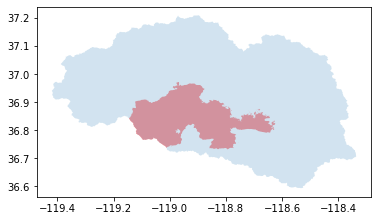

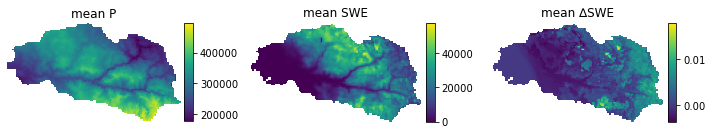

100%|██████████| 5807/5807 [10:18<00:00,  9.39it/s]


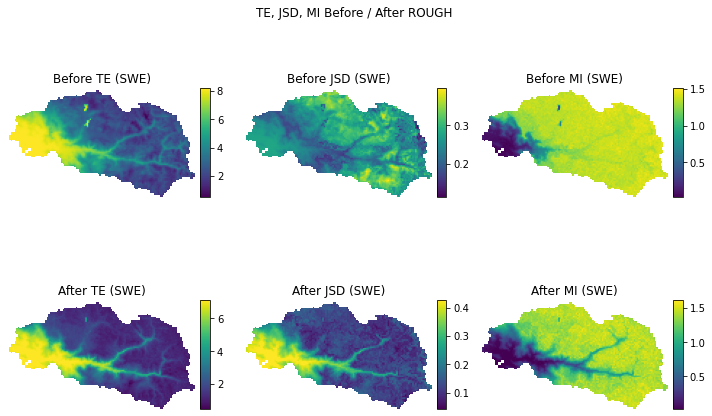

100%|██████████| 8160/8160 [14:32<00:00,  9.35it/s]


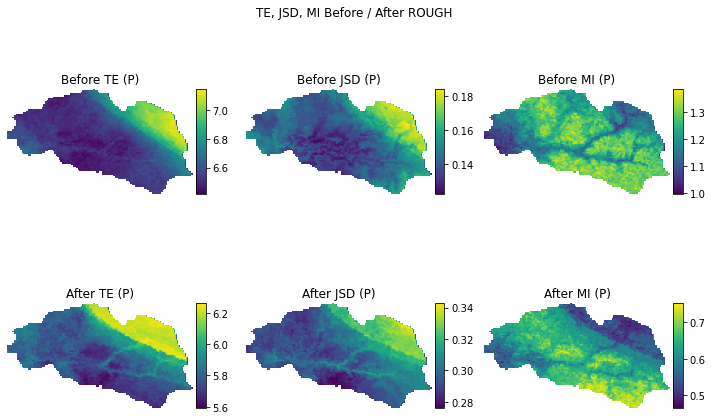

100%|██████████| 5807/5807 [11:04<00:00,  8.73it/s]


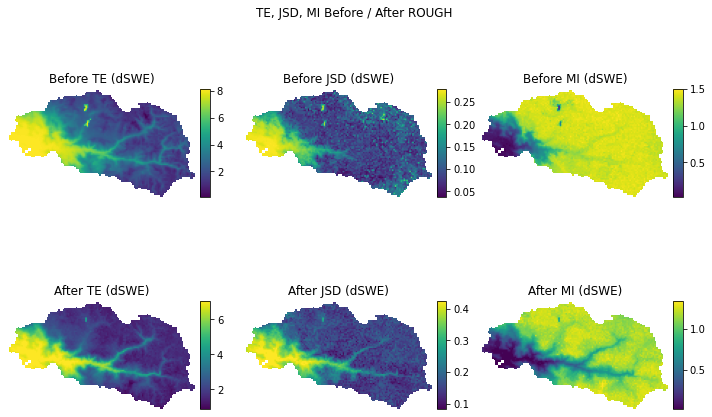

wrote ../rasters/Fire/ROUGH_PNF_b4_p_jsd.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_swe_jsd.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_dswe_jsd.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_p_jsd.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_swe_jsd.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_dswe_jsd.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_p_te.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_swe_te.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_dswe_te.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_p_te.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_swe_te.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_dswe_te.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_p_mi.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_swe_mi.tif
wrote ../rasters/Fire/ROUGH_PNF_b4_dswe_mi.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_p_mi.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_swe_mi.tif
wrote ../rasters/Fire/ROUGH_PNF_aft_dswe_mi.tif
************************************************************
Processing Fire ID: FERGUSON within catchment: MERCED R with reservoir terminus: MCR
2018-07-13 2018-1

<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


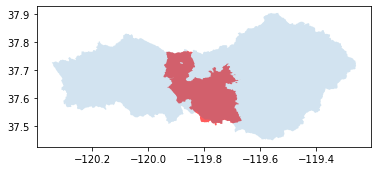

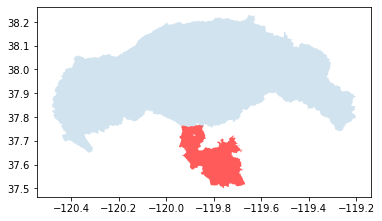

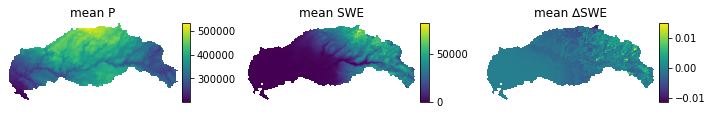

100%|██████████| 5813/5813 [10:10<00:00,  9.51it/s]


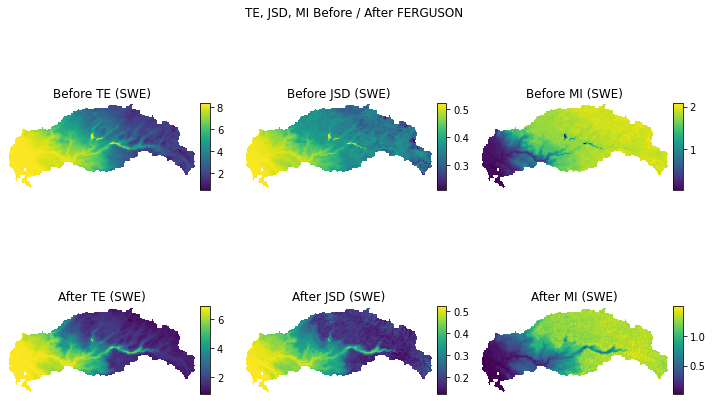

100%|██████████| 9230/9230 [15:59<00:00,  9.62it/s]


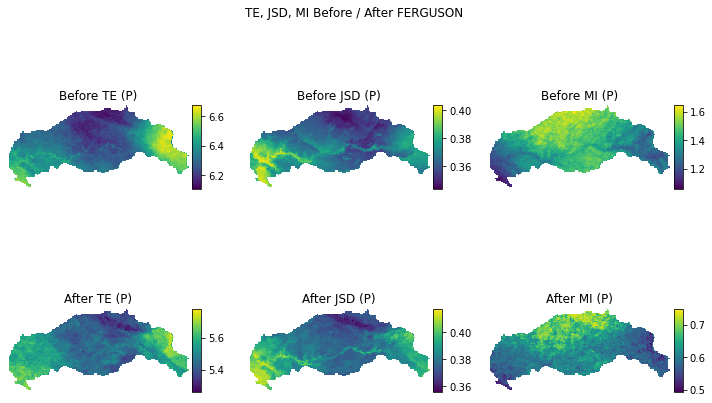

100%|██████████| 5813/5813 [10:19<00:00,  9.38it/s]


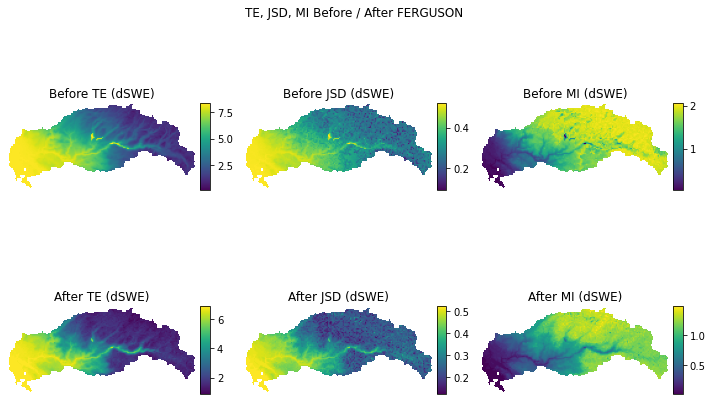

wrote ../rasters/Fire/FERGUSON_DNP_b4_p_jsd.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_swe_jsd.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_dswe_jsd.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_p_jsd.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_swe_jsd.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_dswe_jsd.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_p_te.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_swe_te.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_dswe_te.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_p_te.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_swe_te.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_dswe_te.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_p_mi.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_swe_mi.tif
wrote ../rasters/Fire/FERGUSON_DNP_b4_dswe_mi.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_p_mi.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_swe_mi.tif
wrote ../rasters/Fire/FERGUSON_DNP_aft_dswe_mi.tif
************************************************************
Processing Fire ID: BARRY POINT within catchment

<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


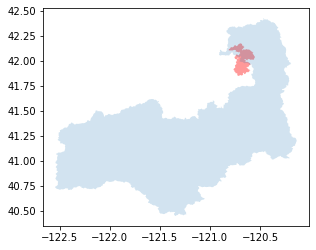

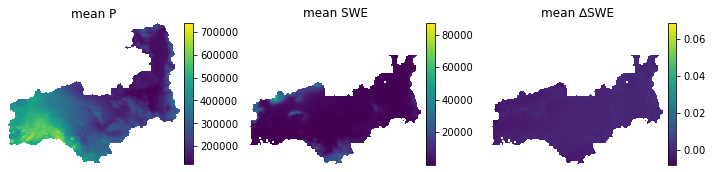

100%|██████████| 26800/26800 [48:40<00:00,  9.18it/s]


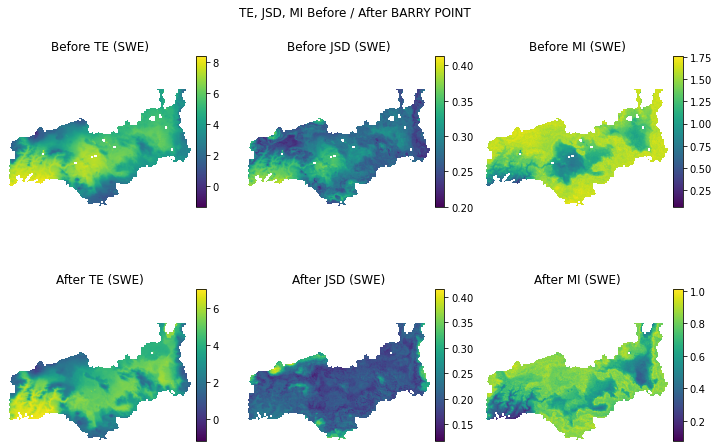

100%|██████████| 58911/58911 [1:46:28<00:00,  9.22it/s]  


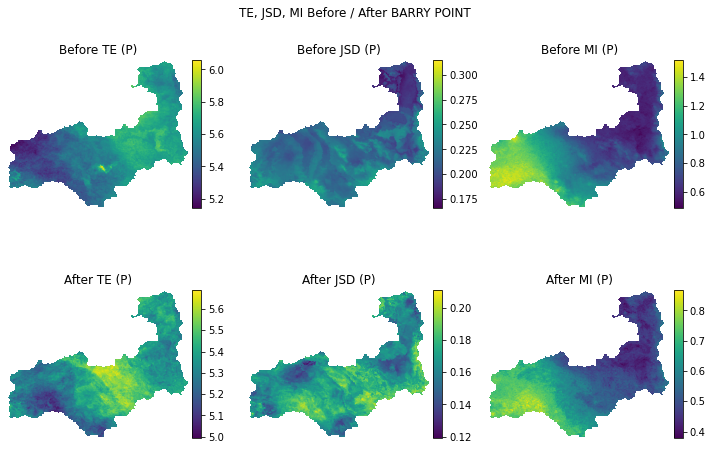

100%|██████████| 26800/26800 [48:14<00:00,  9.26it/s]


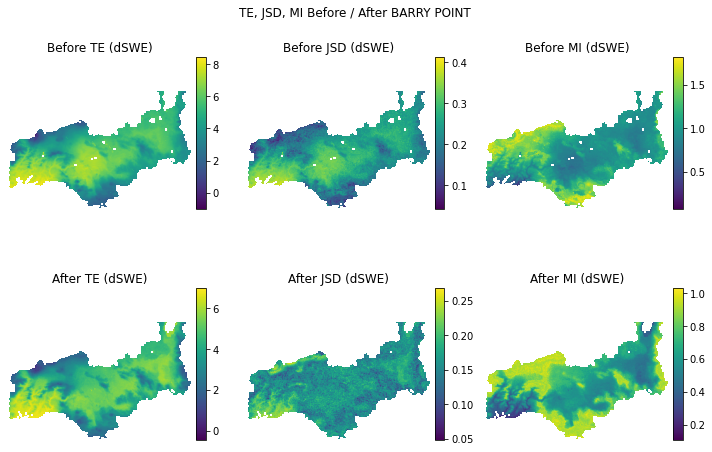

wrote ../rasters/Fire/BARRY POINT_SHA_b4_p_jsd.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_swe_jsd.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_dswe_jsd.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_p_jsd.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_swe_jsd.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_dswe_jsd.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_p_te.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_swe_te.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_dswe_te.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_p_te.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_swe_te.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_dswe_te.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_p_mi.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_swe_mi.tif
wrote ../rasters/Fire/BARRY POINT_SHA_b4_dswe_mi.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_p_mi.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_swe_mi.tif
wrote ../rasters/Fire/BARRY POINT_SHA_aft_dswe_mi.tif
*******************************************************

<ipython-input-13-00bf556a8ef8>:74: RuntimeWarning: Mean of empty slice
  pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]


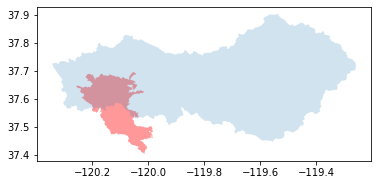

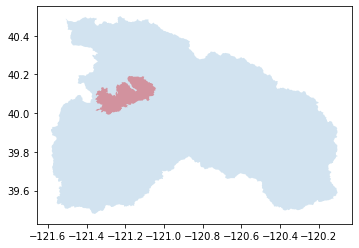

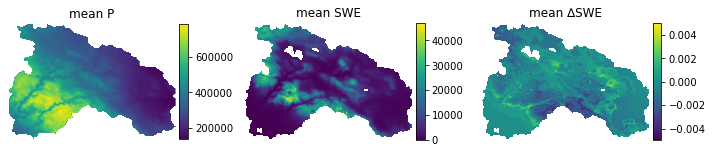

100%|██████████| 14056/14056 [25:11<00:00,  9.30it/s]


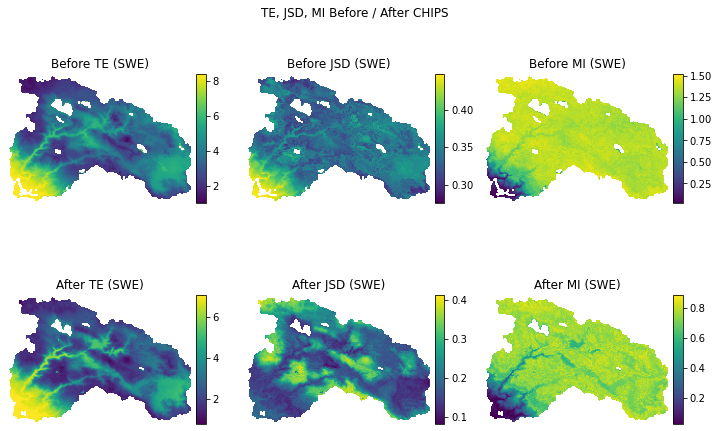

100%|██████████| 18645/18645 [33:04<00:00,  9.39it/s]


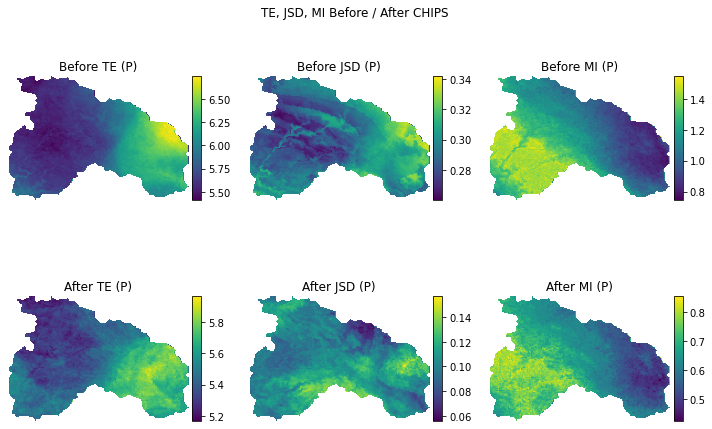

100%|██████████| 14056/14056 [25:29<00:00,  9.19it/s]


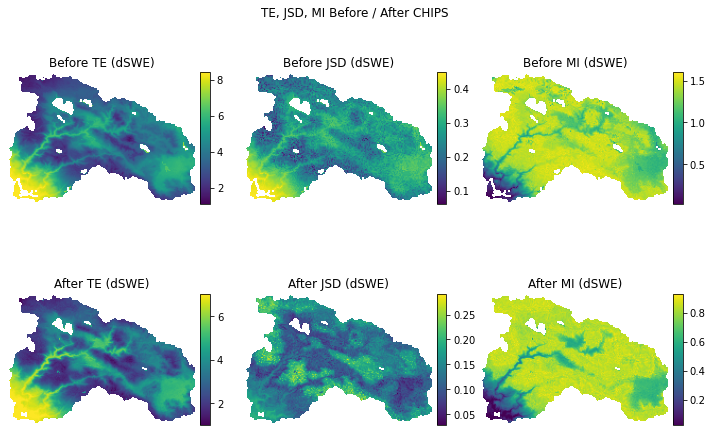

wrote ../rasters/Fire/CHIPS_ORO_b4_p_jsd.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_swe_jsd.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_dswe_jsd.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_p_jsd.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_swe_jsd.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_dswe_jsd.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_p_te.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_swe_te.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_dswe_te.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_p_te.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_swe_te.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_dswe_te.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_p_mi.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_swe_mi.tif
wrote ../rasters/Fire/CHIPS_ORO_b4_dswe_mi.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_p_mi.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_swe_mi.tif
wrote ../rasters/Fire/CHIPS_ORO_aft_dswe_mi.tif


In [13]:
for idx, x in topten[::-1].iterrows():
    print("****" * 15)
    stn_id = x['stid']
    catch_shp = "../shape/{}.shp".format(stn_id)
    fire_id = x['FIRE_NAME']
    print("Processing Fire ID: {} within catchment: {} with reservoir terminus: {}".format(fire_id, x['catch_name'],stn_id))

    # Set filepaths
    resfn = os.path.join('../data/res_inflow/{}_res.csv'.format(stn_id))
    swestack_fn = os.path.join('../data/swe/{}_swe.npy'.format(stn_id))
    pstack_fn = os.path.join('../data/prcp/{}_prcp.npy'.format(stn_id))
    
    print(x['ALARM_DATE'], x['CONT_DATE'], x['GIS_ACRES'],x['stid'])
    
    ax = topten[topten['FIRE_NAME']==fire_id].plot(color = 'red', alpha = 0.4)
    gdf[gdf['stid']==stn_id].plot(ax = ax, alpha = 0.2)
    
    # Get the daily reservoir inflow
    if not os.path.exists(resfn):
        try:
            inflow = rs.col_to_dt(get_res_data(stn_id, startdate, enddate))
            inflow.to_csv(resfn)
        except:
            print("no data for {}".format(stn_id))
            continue
    else:
        inflow = rs.col_to_dt(pd.read_csv(resfn))
        if len(inflow) == 0:
            print("no data for {}".format(stn_id))
            continue

    # Get the SWE
    if not os.path.exists(swestack_fn):
        swe = get_snodas_swe(catch_shp, startdate, enddate)
        swevals = swe.values()
        swestack = np.dstack(list(swe.values()))
        np.save(swestack_fn, swestack)
    else:
        swestack = np.load(swestack_fn)
        swevals = [swestack[:,:,t] for t in range(0, swestack.shape[2])]
    
    # Calc dSWE in time dim
    dswe = np.diff(swestack, axis = 2)

    # Get the P data
    if not os.path.exists(pstack_fn):
        rsdat = rs.load_data()
        area = rs.gdf_to_ee_poly(gp.read_file(catch_shp))
        pdat = rs.get_daily_ims(rsdat['dmet'], startdate, enddate, area, return_dates = True)
        
        pstack = np.dstack(list(pdat.values()))
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        np.save(pstack_fn, pstack)
    else:
        pstack = np.load(pstack_fn)
        pvals = [pstack[:,:,t] for t in range(0, pstack.shape[2])]
        
    # Split before / 2 years after fire
    dt_idx = pd.date_range('2003-09-30','2020-10-01', freq='D')
    beforeidx = (dt_idx[dt_idx < x['ALARM_DATE']])
    timespan = datetime.datetime.strptime(x['CONT_DATE'], "%Y-%m-%d") + relativedelta(years = 2) # 3 year timespan
    afteridx = (dt_idx[dt_idx > x['CONT_DATE']]& dt_idx[dt_idx < timespan])
        
    beforeP, afterP = split_before_after(pstack, len(beforeidx),len(afteridx))
    beforeSWE, afterSWE = split_before_after(swestack, len(beforeidx),len(afteridx))
    beforedSWE, afterdSWE = split_before_after(dswe, len(beforeidx),len(afteridx))
    
    # We can't compute things that need δsres for Merced b/c it doesn't have data 
    if stn_id == "MCR" or stn_id == "CFW":
        print("No Reservoir data for {}".format(stn_id))
        continue
        
    # Get annual mean ims 
    pmean, swemean, dswemean = [np.nanmean(x, axis = 2)*365 for x in [pstack, swestack,dswe]]
    pmean[pmean == 0] = np.nan
    
    plot_mean_ims(pmean,swemean,dswemean, stid = stn_id)

    # Main routines
    
    # Swe
    b4swe = calc_main(beforeSWE, beforeidx, dswe = False, inflow = inflow)
    aftswe = calc_main(afterSWE, afteridx, dswe = False, inflow = inflow)
    b4_swe_te, b4_swe_jsd, b4_swe_mi = mask_unpack(b4swe, swemean)
    aft_swe_te, aft_swe_jsd, aft_swe_mi = mask_unpack(aftswe, swemean)
    plot_before_after([b4_swe_te, b4_swe_jsd, b4_swe_mi],[aft_swe_te,aft_swe_jsd, aft_swe_mi], var = "SWE", stid = stn_id, fire_name = fire_id)

    # Precip
    b4p = calc_main(beforeP, beforeidx, dswe = False, inflow = inflow)
    aftp = calc_main(afterP, afteridx, dswe = False, inflow = inflow)
    b4_p_te,b4_p_jsd, b4_p_mi  = mask_unpack(b4p, pmean) # Unpack and plot
    aft_p_te,aft_p_jsd, aft_p_mi  = mask_unpack(aftp, pmean)
    plot_before_after([b4_p_te, b4_p_jsd, b4_p_mi],[aft_p_te,aft_p_jsd, aft_p_mi], var = "P", stid = stn_id, fire_name = fire_id)

    # Dswe 
    b4dswe = calc_main(beforedSWE, beforeidx, dswe = False, inflow = inflow)
    aftdswe = calc_main(afterdSWE, afteridx, dswe = False, inflow = inflow)
    b4_dswe_te,b4_dswe_jsd, b4_dswe_mi  = mask_unpack(b4dswe, swemean)
    aft_dswe_te,aft_dswe_jsd, aft_dswe_mi  = mask_unpack(aftdswe, swemean)
    plot_before_after([b4_dswe_te, b4_dswe_jsd, b4_dswe_mi],[aft_dswe_te,aft_dswe_jsd, aft_dswe_mi], var = "dSWE", stid = stn_id, fire_name = fire_id)
    
    # Write files 
    outdir = "../rasters/Fire"
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    b4_p_jsd_fn = os.path.join(outdir,"{}_{}_b4_p_jsd.tif".format(fire_id, stn_id))
    b4_swe_jsd_fn = os.path.join(outdir,"{}_{}_b4_swe_jsd.tif".format(fire_id, stn_id))
    b4_dswe_jsd_fn = os.path.join(outdir,"{}_{}_b4_dswe_jsd.tif".format(fire_id, stn_id))
    
    aft_p_jsd_fn = os.path.join(outdir,"{}_{}_aft_p_jsd.tif".format(fire_id, stn_id))
    aft_swe_jsd_fn = os.path.join(outdir,"{}_{}_aft_swe_jsd.tif".format(fire_id, stn_id))
    aft_dswe_jsd_fn = os.path.join(outdir,"{}_{}_aft_dswe_jsd.tif".format(fire_id, stn_id))
    
    b4_p_mi_fn = os.path.join(outdir,"{}_{}_b4_p_mi.tif".format(fire_id, stn_id))
    b4_swe_mi_fn = os.path.join(outdir,"{}_{}_b4_swe_mi.tif".format(fire_id, stn_id))
    b4_dswe_mi_fn = os.path.join(outdir,"{}_{}_b4_dswe_mi.tif".format(fire_id, stn_id))
    
    aft_p_mi_fn = os.path.join(outdir,"{}_{}_aft_p_mi.tif".format(fire_id, stn_id))
    aft_swe_mi_fn = os.path.join(outdir,"{}_{}_aft_swe_mi.tif".format(fire_id, stn_id))
    aft_dswe_mi_fn = os.path.join(outdir,"{}_{}_aft_dswe_mi.tif".format(fire_id, stn_id))
    
    b4_p_te_fn = os.path.join(outdir,"{}_{}_b4_p_te.tif".format(fire_id, stn_id))
    b4_swe_te_fn = os.path.join(outdir,"{}_{}_b4_swe_te.tif".format(fire_id, stn_id))
    b4_dswe_te_fn = os.path.join(outdir,"{}_{}_b4_dswe_te.tif".format(fire_id, stn_id))
    
    aft_p_te_fn = os.path.join(outdir,"{}_{}_aft_p_te.tif".format(fire_id, stn_id))
    aft_swe_te_fn = os.path.join(outdir,"{}_{}_aft_swe_te.tif".format(fire_id, stn_id))
    aft_dswe_te_fn = os.path.join(outdir,"{}_{}_aft_dswe_te.tif".format(fire_id, stn_id))



    # Write before JSD
    for im, fn in zip([b4_p_jsd, b4_swe_jsd, b4_dswe_jsd], [b4_p_jsd_fn, b4_swe_jsd_fn, b4_dswe_jsd_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)

    # Write after JSD
    for im, fn in zip([aft_p_jsd, aft_swe_jsd, aft_dswe_jsd], [aft_p_jsd_fn, aft_swe_jsd_fn, aft_dswe_jsd_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)
    
    # Write before TE
    for im, fn in zip([b4_p_te, b4_swe_te, b4_dswe_te], [b4_p_te_fn, b4_swe_te_fn, b4_dswe_te_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)

    # Write after TE
    for im, fn in zip([aft_p_te, aft_swe_te, aft_dswe_te], [aft_p_te_fn, aft_swe_te_fn, aft_dswe_te_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)
    
    # Write before MI
    for im, fn in zip([b4_p_mi, b4_swe_mi, b4_dswe_mi], [b4_p_mi_fn, b4_swe_mi_fn, b4_dswe_mi_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)

    # Wrimi after MI
    for im, fn in zip([aft_p_mi, aft_swe_mi, aft_dswe_mi], [aft_p_mi_fn, aft_swe_mi_fn, aft_dswe_mi_fn]):
        rs.write_raster(im, gp.read_file(catch_shp), fn)